<a href="https://colab.research.google.com/github/abhinavjha98/deploying_flower/blob/master/crop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Imports here
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import helper
from collections import OrderedDict
from PIL import Image
import matplotlib.pyplot as plt

In [0]:
!wget -O flower_data.zip "https://github.com/abhinavjha98/crop_dataset/archive/master.zip"
!unzip flower_data.zip

--2019-02-17 08:35:47--  https://github.com/abhinavjha98/crop_dataset/archive/master.zip
Resolving github.com (github.com)... 192.30.253.113, 192.30.253.112
Connecting to github.com (github.com)|192.30.253.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/abhinavjha98/crop_dataset/zip/master [following]
--2019-02-17 08:35:48--  https://codeload.github.com/abhinavjha98/crop_dataset/zip/master
Resolving codeload.github.com (codeload.github.com)... 192.30.253.121, 192.30.253.120
Connecting to codeload.github.com (codeload.github.com)|192.30.253.121|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘flower_data.zip’

flower_data.zip         [         <=>        ]  52.81M  24.0MB/s    in 2.2s    

2019-02-17 08:35:50 (24.0 MB/s) - ‘flower_data.zip’ saved [55375663]

Archive:  flower_data.zip
5879e408199cb116c9b213e724f7f37983f8d0d5
   creating: crop_dataset-master/
 

In [0]:

data_dir = 'crop_dataset-master'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

In [0]:
# TODO: Define your transforms for the training, validation, and testing sets
data_transforms = {'train' : transforms.Compose([transforms.RandomRotation(30),
                                                 transforms.RandomResizedCrop(224),
                                                 transforms.RandomHorizontalFlip(),
                                                 transforms.ToTensor(),
                                                 transforms.Normalize([0.485, 0.456, 0.406],
                                                                      [0.229, 0.224, 0.225])]),
                   'validate' : transforms.Compose([transforms.Resize(255),
                                                    transforms.CenterCrop(224),
                                                    transforms.ToTensor(),
                                                    transforms.Normalize([0.485, 0.456, 0.406],
                                                                         [0.229, 0.224, 0.225])])}
                   

# TODO: Load the datasets with ImageFolder
image_datasets = {'train' : datasets.ImageFolder(train_dir, transform=data_transforms['train']),
                  'validate' : datasets.ImageFolder(valid_dir, transform=data_transforms['validate']),
                  'test' : datasets.ImageFolder(test_dir, transform=data_transforms['validate'])}

# TODO: Using the image datasets and the trainforms, define the dataloaders
dataloaders = {'train' : torch.utils.data.DataLoader(image_datasets['train'], batch_size=64, shuffle=True),
               'validate' : torch.utils.data.DataLoader(image_datasets['validate'], batch_size=64),
               'test' : torch.utils.data.DataLoader(image_datasets['test'], batch_size=64)}

In [0]:
import json

with open('cat_to_names.json', 'r') as f:
    cat_to_name = json.load(f)

In [0]:
cat_to_name['10']

'damaged_rice'

In [0]:
def make_classifier(input_units, hidden_units, dropout):
    '''
    Defines custom classifier
    
    Returns: classifier
    '''
    classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(input_units, hidden_units)),
                          ('relu', nn.ReLU()),
                          ('dropout', nn.Dropout(p=dropout)),
                          ('fc2', nn.Linear(hidden_units, 102)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))
    return classifier


def make_model(base_model, hidden_units, dropout, learn_rate):
    '''
    Loads base model and freezes parameters so we don't train them.
    Replaces classifier with custom classifier.
    Defines loss function and optimizer.
    
    Returns: model, criterion, optimizer 
    '''
    
    assert base_model in ['vgg11', 'vgg13', 'vgg16', 'vgg19', 'alexnet', 'densenet121', 'densenet169',
                      'densenet161', 'densenet201']
        
    model = getattr(models, base_model)(pretrained=True)
    try:
        input_units=model.classifier[0].in_features
    except (AttributeError):
        input_units=model.classifier[1].in_features
    except (TypeError):
        input_units=model.classifier.in_features

    # Freeze parameters
    for param in model.parameters():
        param.requires_grad = False

    # Replace existing classifier with custom classifier
    classifier = make_classifier(input_units, hidden_units, dropout)
    model.classifier = classifier
    
    # Define loss function and Optimizer
    criterion = nn.NLLLoss()
    optimizer = optim.Adam(model.classifier.parameters(), lr=learn_rate)
    
    return model, criterion, optimizer


def validate_model(model, testloader, criterion):
    '''
    Calculates average loss per batch and average accuracy for testloader
    
    Returns: average loss and accuracy
    '''
    
    model.eval()
    test_loss = 0
    accuracy = 0
    steps = 0
    for inputs, labels in testloader:

        inputs, labels = inputs.to('cuda'), labels.to('cuda')

        output = model.forward(inputs)
        test_loss += criterion(output, labels).item()

        ps = torch.exp(output)
        equality = (labels.data == ps.max(dim=1)[1])
        accuracy += equality.type(torch.FloatTensor).mean()
        steps += 1
    return test_loss/steps, float(accuracy) * 100/steps


def train_model(model, criterion, optimizer, training_dataloader, validation_dataloader, epochs, gpu):
    '''
    Train model
    
    Returns: Trained model
    '''
    if gpu:
        model.to('cuda')
       
    print_every = 20
    running_loss = 0
    for e in range(epochs):
        model.train()
        steps = 0
        for ii, (inputs, labels) in enumerate(training_dataloader):
            steps += 1

            if gpu:
                inputs, labels = inputs.to('cuda'), labels.to('cuda')

            optimizer.zero_grad()

            # Forward and backward passes
            outputs = model.forward(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            if steps % print_every == 0:
                print("Epoch: {}/{}... ".format(e+1, epochs),
                      "Loss: {:.4f}".format(running_loss/print_every))

                running_loss = 0
        loss, accuracy = validate_model(model, validation_dataloader, criterion)
        print('Average loss per validation batch: {0:.2f}'.format(loss))
        print('Accuracy on validation images: {0:.2f}'.format(round(accuracy,2)))
        
    return model

In [0]:
# TODO: Build and train your network

# Build model
base_model='vgg19'
hidden_units=1024
dropout=0.5
learn_rate=0.001
epochs=20
gpu=True

model, criterion, optimizer = make_model(base_model, hidden_units, dropout, learn_rate)

# Train model
model = train_model(model, criterion, optimizer, dataloaders['train'],
                    dataloaders['validate'], epochs, gpu)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.torch/models/vgg19-dcbb9e9d.pth
574673361it [00:06, 91407417.41it/s]


Average loss per validation batch: 2.21
Accuracy on validation images: 28.65
Average loss per validation batch: 2.26
Accuracy on validation images: 48.34
Average loss per validation batch: 2.62
Accuracy on validation images: 43.45
Average loss per validation batch: 1.90
Accuracy on validation images: 53.12
Average loss per validation batch: 1.92
Accuracy on validation images: 64.34
Average loss per validation batch: 2.03
Accuracy on validation images: 62.85
Average loss per validation batch: 2.26
Accuracy on validation images: 64.44
Average loss per validation batch: 2.36
Accuracy on validation images: 68.37
Average loss per validation batch: 2.46
Accuracy on validation images: 61.09
Average loss per validation batch: 2.53
Accuracy on validation images: 61.87
Average loss per validation batch: 2.59
Accuracy on validation images: 59.48
Average loss per validation batch: 2.37
Accuracy on validation images: 63.51
Average loss per validation batch: 2.20
Accuracy on validation images: 65.95

In [0]:
test_loss, test_accuracy = validate_model(model, dataloaders['test'], criterion)
print('Accuracy on test images: {0:.2f}%'.format(round(test_accuracy,2)))

Accuracy on test images: 72.66%


In [0]:
def save_model(model, dir_path, base_model, hidden_units, dropout, learn_rate):
    '''
    Save checkpoint
    
    Return: checkpoint
    '''
    
    checkpoint = {'base_model': base_model,
                  'hidden_units': hidden_units,
                  'dropout': dropout,
                  'learn_rate': learn_rate,
                  'model_state_dict': model.state_dict(),
                  'class_to_idx': model.class_to_idx}
    torch.save(checkpoint, dir_path + '/checkpoints.pth')
    
    return checkpoint

In [0]:
# TODO: Save the checkpoint 

# Add class_to_idx dictionary as model attribute
model.class_to_idx = image_datasets['train'].class_to_idx
idx_to_cat = {value:key for key, value in model.class_to_idx.items()}

# Save checkpoint
checkpoint = save_model(model, '.', base_model, hidden_units, dropout, learn_rate)

In [0]:
# TODO: Write a function that loads a checkpoint and rebuilds the model

def load_model(checkpoint_path, gpu):
    '''
    Loads vgg19 pretrained model, replaces classifier with custom classifier,
    loads model_state_dict from checkpoint file, defines loss criterion and optimizer,
    makes index to category dictionary.
    
    Returns: model, criterion, optimizer, idx_to_cat
    '''
    
    if gpu:
        checkpoint = torch.load(checkpoint_path)
    else:
        checkpoint = torch.load(checkpoint_path, map_location='cpu')
    
    base_model = checkpoint['base_model']
    hidden_units = checkpoint['hidden_units']
    dropout = checkpoint['dropout']
    learn_rate = checkpoint['learn_rate']
    
    # Load base model and attach custom classifier
    model, criterion, optimizer = make_model(base_model, hidden_units, dropout, learn_rate)
    
    # Load the model_state_dict from checkpoint file
    model.load_state_dict(checkpoint['model_state_dict'])
    
    # Make dictionary for index to category
    cat_to_idx = checkpoint['class_to_idx']
    idx_to_cat = {value:key for key, value in cat_to_idx.items()}
    
    return model, criterion, optimizer, idx_to_cat

In [0]:
model, criterion, optimizer, idx_to_cat = load_model('checkpoints.pth', gpu=False)

In [0]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    
    # TODO: Process a PIL image for use in a PyTorch model
    
    im = Image.open(image)
    
    # Resize image with shortest side 256
    if im.size[0] > im.size[1]:
        im.thumbnail((1000,256))
    else:
        im.thumbnail((256,1000))
    
    # Center crop to 224x224
    left = (im.width - 224)/2
    upper = (im.height - 224)/2
    right = left + 224
    lower = upper + 224
    im = im.crop((left, upper, right, lower))
    
    # Normalize
    np_im = np.array(im)/255
    means = np.array([0.485, 0.456, 0.406])
    stds = np.array([0.229, 0.224, 0.225])
    np_im = (np_im - means)/stds
    
    # Reorder dimensions, third to first with same order of other 2
    np_im = np_im.transpose((2,0,1))
    
    return np_im

In [0]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

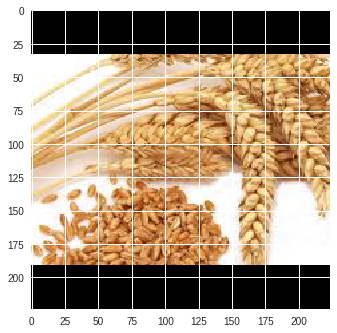

In [0]:
np_im = process_image('crop_dataset-master/train/1/images.jpg')
imshow(np_im)

In [0]:
def predict(image_path, model, topk, gpu):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    
    # TODO: Implement the code to predict the class from an image file
    
    # Process image and make into torch tensor of correct shape
    np_im = process_image(image_path)
    torch_im = torch.tensor(np_im, dtype=torch.float).unsqueeze(0)
    
    # If using gpu model and image are in correct format
    if gpu:
        model.to('cuda')
        torch_im = torch_im.to('cuda')
    
    # Put model in eval mode (no dropout)
    model.eval()
    
    # Perform forward pass without keeping track of gradients
    with torch.no_grad():
        output = model.forward(torch_im)
    
    # Get top K categories and probabilities
    predicted_prob, predicted_idx = torch.exp(output).data.topk(topk)  
    predicted_prob = (predicted_prob.cpu().numpy().reshape((topk)) * 100).round(0)
    predicted_cat = [idx_to_cat[idx] for idx in predicted_idx.cpu().numpy().reshape((topk))]
    
    return predicted_prob, predicted_cat

In [0]:
def view_classify(img_path, model, idx_to_name, topk, gpu):
    '''
    Display image along with top K predicted species names
    '''
    # Predict
    prob, cat = predict(img_path, model, topk, gpu)
    
    # Get names
    names = [cat_to_name[i] for i in cat]
    
    # Plot image
    im = Image.open(img_path)
    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), nrows=2)
    ax1.imshow(im)
    ax1.axis('off')
    
    # Plot bar graph
    ax2.barh(np.arange(5), prob)
    ax2.set_yticks(np.arange(5))
    ax2.set_yticklabels(names)
    ax2.set_title('Class Probability')

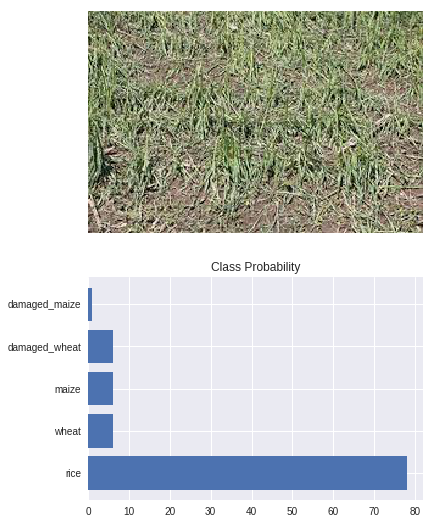

In [0]:
idx_to_name = {idx:cat_to_name[cat] for idx, cat in idx_to_cat.items()}
view_classify(train_dir + '/2/img11.jpg', model, idx_to_name, 5, False)

In [0]:
import dill as dill
torch.save('checkpoints.pth',map_location='cpu', pickle_module=dill)

TypeError: ignored

In [0]:
model.class_to_idx = image_datasets['train'].class_to_idx
model.cpu()
torch.save({'arch': 'vgg19',
            'state_dict': model.state_dict(), 
            'class_to_idx': model.class_to_idx}, 
            'classifier.pth')